### IMPORTS

In [1]:
# manipulate data
import numpy as np
import pandas as pd

# statistical tests
import scipy as sp

# visualize data
import matplotlib.pyplot as plt
import seaborn as sn

# model preparation
from sklearn.model_selection import (train_test_split, learning_curve,
                                     LearningCurveDisplay, validation_curve,
                                     ValidationCurveDisplay)
from sklearn.preprocessing import StandardScaler

# pytorch
import torch as pt

# machine learning models
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

# model evaluation
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                            RocCurveDisplay, accuracy_score, f1_score,
                            precision_score, recall_score)

np.random.seed(123)
pd.options.display.max_columns = 100

### Load and Preprocess: Cardiovascular Disease

In [2]:
file1 = "cardio_data_processed.csv"
cardio_vasc = pd.read_csv(file1)

In [3]:
# id: just an index
# useing age_years over age
# using weight and height instead of bmi
# using ap_hi/lo instead of bp_category and bp_category_encoded
cardio_cols_drop = ['id', 'age', 'bmi', 'bp_category', 'bp_category_encoded', "alco", "smoke"]
cardio_vasc = cardio_vasc.drop(columns=cardio_cols_drop, axis=1)

In [4]:
cols_convert = ['gender', 'cholesterol', 'gluc', 'active', 'cardio']
cardio_vasc[cols_convert] = cardio_vasc[cols_convert].astype('category')

In [5]:
cardio_vasc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68205 entries, 0 to 68204
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   gender       68205 non-null  category
 1   height       68205 non-null  int64   
 2   weight       68205 non-null  float64 
 3   ap_hi        68205 non-null  int64   
 4   ap_lo        68205 non-null  int64   
 5   cholesterol  68205 non-null  category
 6   gluc         68205 non-null  category
 7   active       68205 non-null  category
 8   cardio       68205 non-null  category
 9   age_years    68205 non-null  int64   
dtypes: category(5), float64(1), int64(4)
memory usage: 2.9 MB


In [6]:
cardio_vasc.head(3)

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,active,cardio,age_years
0,2,168,62.0,110,80,1,1,1,0,50
1,1,156,85.0,140,90,3,1,1,1,55
2,1,165,64.0,130,70,3,1,0,1,51


In [7]:
# split data
cd_train, cd_test = train_test_split(cardio_vasc, test_size=.15,
                                     random_state=123, stratify=cardio_vasc['cardio'])

# get X, y
target_col="cardio"
cols_drop=["cardio"]
X_train_cd = cd_train.drop(cols_drop, axis=1)
X_test_cd = cd_test.drop(cols_drop, axis=1)
y_train_cd = cd_train[target_col]
y_test_cd = cd_test[target_col]

### Baseline: Cardiovascular Disease

In [8]:
# calculat a baseline
act_pred_error_cd = pd.DataFrame({"actual": y_train_cd})
act_pred_error_cd["baseline_prediction"] = y_train_cd.value_counts().index[0]

baseline_acc_cd = accuracy_score(act_pred_error_cd["actual"], act_pred_error_cd["baseline_prediction"])

# print baseline accuracy
print(f"Baseline Accuracy Score: {round(baseline_acc_cd, 2)}%")

Baseline Accuracy Score: 0.51%


### Run Model: Cardiovascular Disease
#### Learning/Validation Curve: Cardiovascular Disease

In [24]:
# create dictionary for each model
class_modelsCD = {'decision tree':{'model': DecisionTreeClassifier(random_state=123,
                                                                   class_weight='balanced')},
                  'knn':{'model': KNeighborsClassifier(n_jobs=-1)},
                  'gradient boosting':{'model': GradientBoostingClassifier(random_state=123)},
                  'support vector machine': {'model': SVC(random_state=123,
                                                          class_weight='balanced')},
                  'mlp':{'model': MLPClassifier(random_state=123)}} # try activation=logistic

In [25]:
cd_params = {'decision tree': {'param1_name': 'min_samples_split', 
                               'param1_range':  [2, 4, 6, 8, 10],
                               'param2_name':'max_depth',
                               'param2_range': [5, 10, 15, 20]},
             'knn': {'param1_name': 'n_neighbors',
                     'param1_range': [3, 5, 7, 9],
                     'param2_name': 'leaf_size',
                     'param2_range': [20, 30, 40, 50]},
             'gradient boosting': {'param1_name': 'n_estimators',
                                   'param1_range': [50, 100, 150, 200],
                                   'param2_name': 'subsample',
                                   'param2_range': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)},
             'mlp': {'param1_name': 'max_iter',
                     'param1_range': [100, 150, 200],
                     'param2_name': 'hidden_layer_sizes',
                     'param2_range': [50, 75, 100, 125, 150]}}

In [26]:
for model_name in class_modelsCD.keys():
    print(f'Working on: {model_name}')
    
    estimator = class_modelsCD[model_name]['model']

    VCparam_name1cd = cd_params[model_name]['param1_name']
    VCparam_range1cd = cd_params[model_name]['param1_range']
    VCparam_name2cd = cd_params[model_name]['param2_name']
    VCparam_range2cd = cd_params[model_name]['param2_range']

    # learning curve
    print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
    fittedLCcd = learning_curve(estimator=estimator,
                                  X=X_train_cd,
                                  y=y_train_cd,
                                  train_sizes=[0.7, 0.75, 0.80, 0.90],
                                  cv=4,
                                  scoring='accuracy',
                                  n_jobs=-1,
                                  random_state=123,
                                  return_times=True)

    # validation curves
    print(f'Fitting VC: Hyper 1 ({VCparam_name1cd}, {VCparam_range1cd})')
    fittedVC_param1cd = validation_curve(estimator=estimator,
                                       X=X_train_cd,
                                       y=y_train_cd,
                                       param_name=VCparam_name1cd,
                                       param_range=VCparam_range1cd,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)

    print(f'Fitting VC: Hyper 2 ({VCparam_name2cd}, {VCparam_range2cd})\n')
    fittedVC_param2cd = validation_curve(estimator=estimator,
                                       X=X_train_cd,
                                       y=y_train_cd,
                                       param_name=VCparam_name2cd,
                                       param_range=VCparam_range2cd,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)
    
    LCtrain_sizescd, LCtrain_scorescd, LCtest_scorescd = fittedLCcd
    VCtrain_scores1cd, VCtest_scores1cd = fittedVC_param1cd
    VCtrain_scores2cd, VCtest_scores2cd = fittedVC_param2cd

    # learning curve to dict
    class_modelsCD[model_name]['LCtrain_sizescd'] = LCtrain_sizescd
    class_modelsCD[model_name]['LCtrain_scorescd'] = LCtrain_scorescd
    class_modelsCD[model_name]['LCtest_scorescd'] = LCtest_scorescd

    # param1 vc to dict
    class_modelsCD[model_name]['VCtrain_scores1cd'] = VCtrain_scores1cd
    class_modelsCD[model_name]['VCtest_scores1cd'] = VCtest_scores1cd

    # param2 vc to dict
    class_modelsCD[model_name]['VCtrain_scores2cd'] = VCtrain_scores2cd
    class_modelsCD[model_name]['VCtest_scores2cd'] = VCtest_scores2cd

Working on: decision tree
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (min_samples_split)
Fitting VC: Hyper 2 (max_depth)

Working on: knn
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (n_neighbors)
Fitting VC: Hyper 2 (leaf_size)

Working on: gradient boosting
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (n_estimators)
Fitting VC: Hyper 2 (subsample)

Working on: support vector machine
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (C)
Fitting VC: Hyper 2 (gamma)



/home/leonardo_leads/miniconda3/envs/ml/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Working on: mlp
Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)
Fitting VC: Hyper 1 (max_iter)
Fitting VC: Hyper 2 (hidden_layer_sizes)



### Visualize Model LC and VC: Cardiovascular Disease

Working on: decision tree
LC (decision tree)
VC: Hyper 1 (min_samples_split)
VC: Hyper 2 (max_depth)


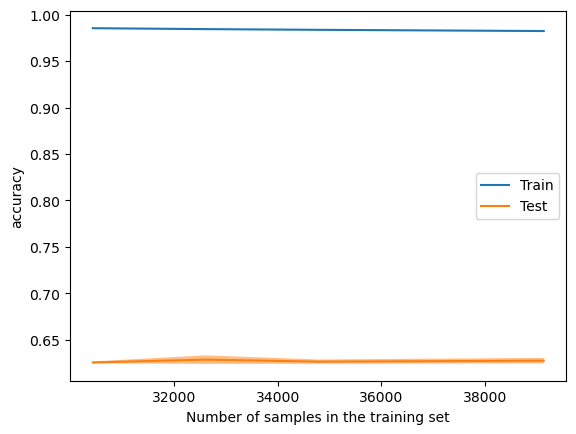

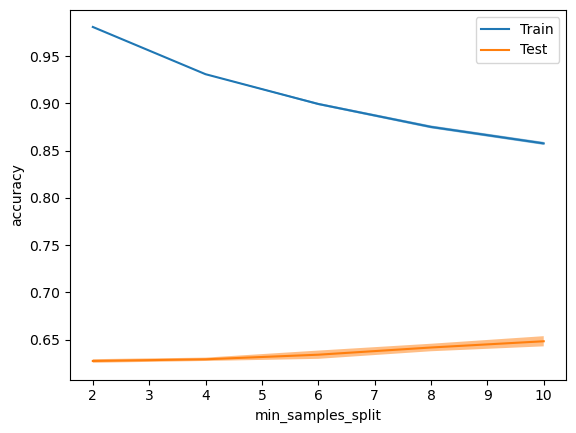

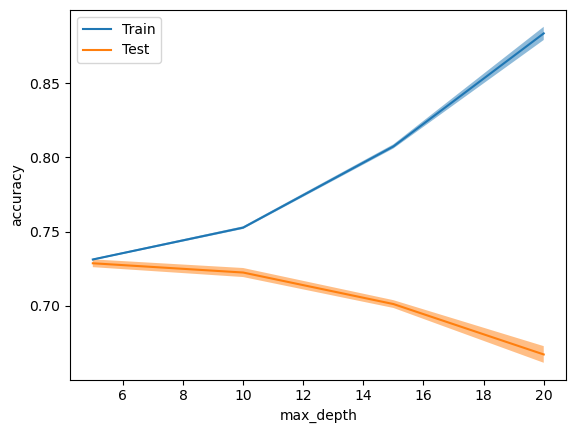

Working on: knn
LC (knn)
VC: Hyper 1 (n_neighbors)
VC: Hyper 2 (leaf_size)


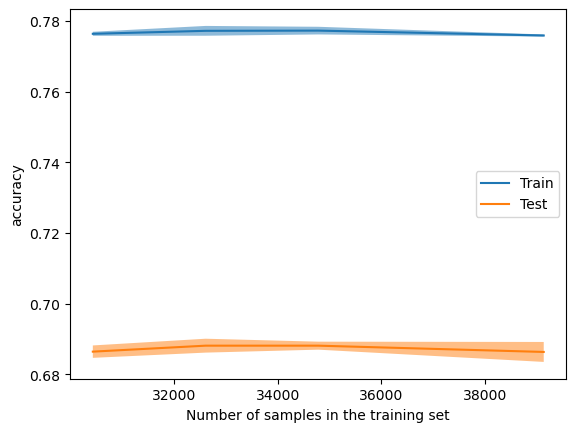

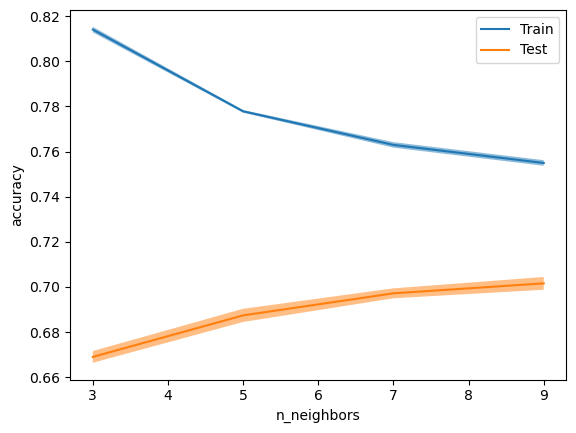

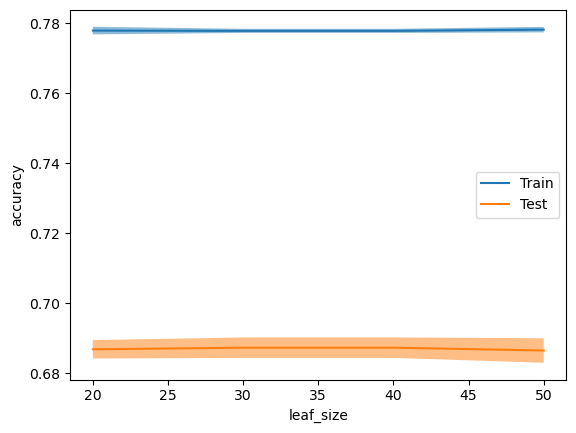

Working on: gradient boosting
LC (gradient boosting)
VC: Hyper 1 (n_estimators)
VC: Hyper 2 (subsample)


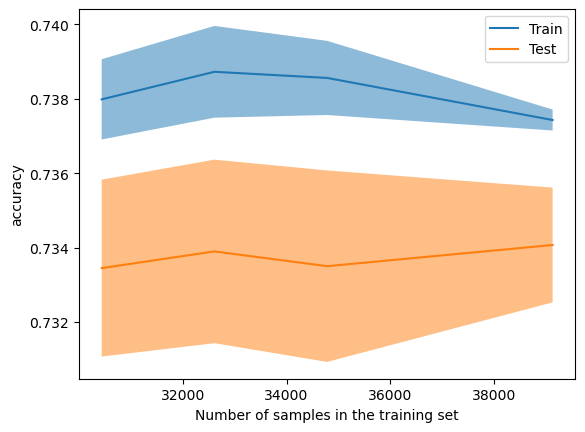

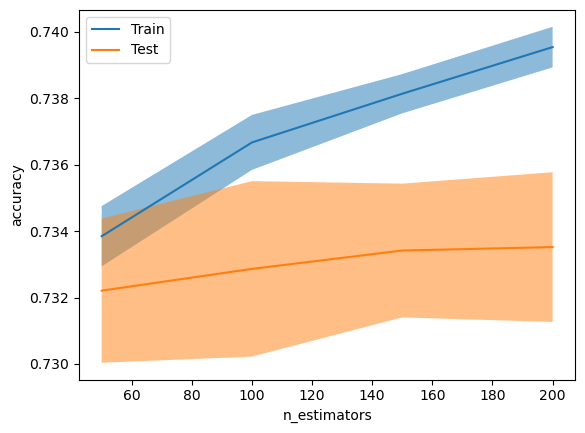

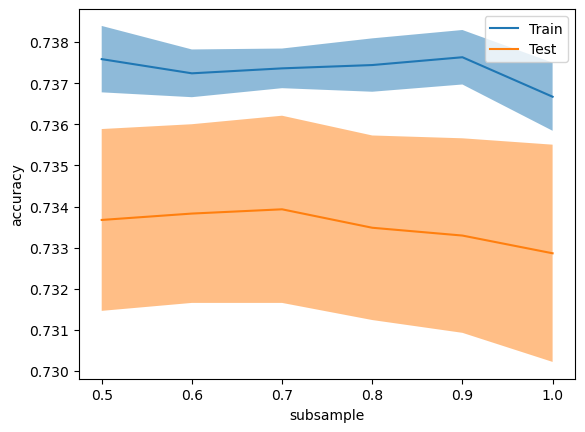

Working on: support vector machine
LC (support vector machine)
VC: Hyper 1 (C)
VC: Hyper 2 (gamma)


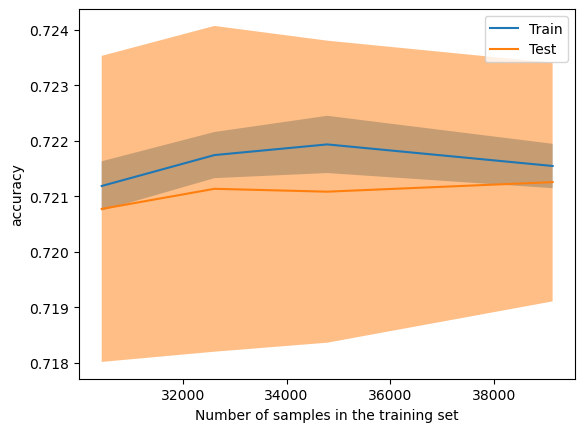

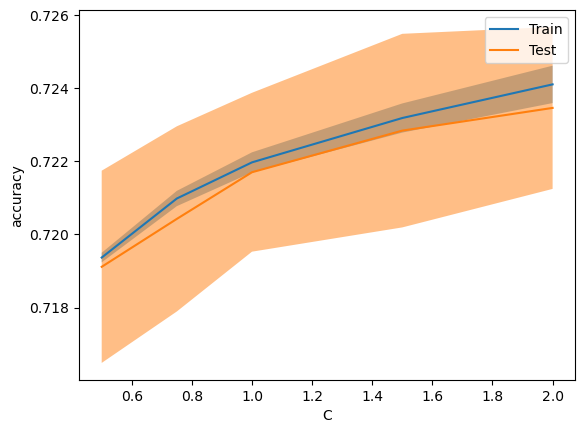

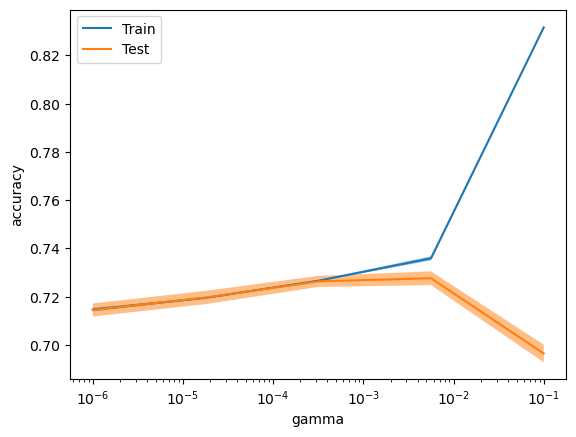

Working on: mlp
LC (mlp)
VC: Hyper 1 (max_iter)
VC: Hyper 2 (hidden_layer_sizes)


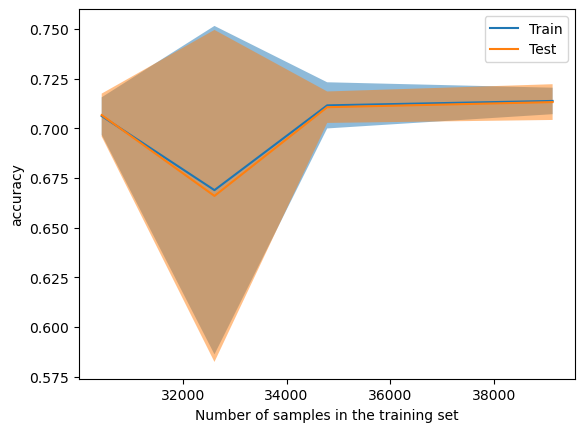

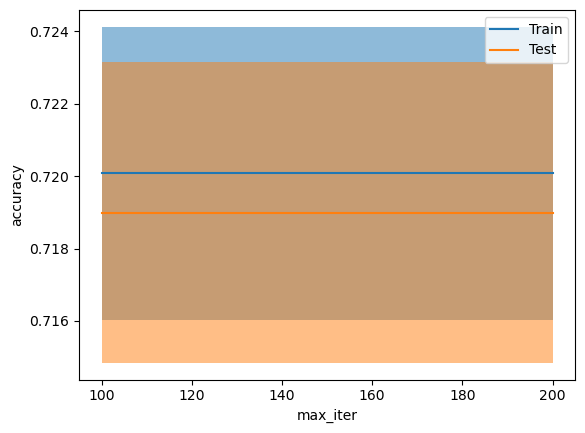

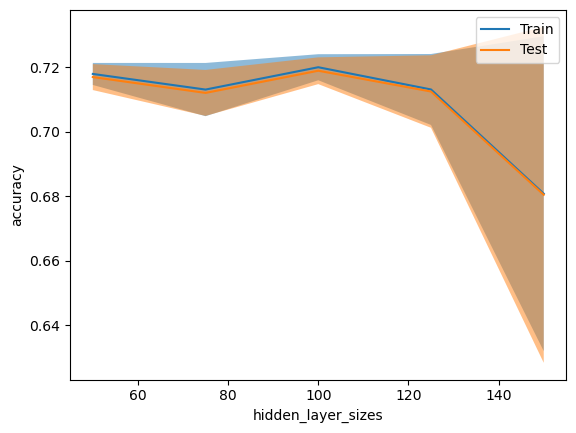

In [27]:
for model_name in class_modelsCD.keys():
    print(f'Working on: {model_name}')

    LCtrain_sizes = class_modelsCD[model_name]['LCtrain_sizescd']
    LCtrain_scores = class_modelsCD[model_name]['LCtrain_scorescd']
    LCtest_scores = class_modelsCD[model_name]['LCtest_scorescd']

    VCtrain_scores1 = class_modelsCD[model_name]['VCtrain_scores1cd']
    VCtest_scores1 = class_modelsCD[model_name]['VCtest_scores1cd']

    VCtrain_scores2 = class_modelsCD[model_name]['VCtrain_scores2cd']
    VCtest_scores2 = class_modelsCD[model_name]['VCtest_scores2cd']

    param1_name = cd_params[model_name]['param1_name']
    param1_range = cd_params[model_name]['param1_range']

    param2_name = cd_params[model_name]['param2_name']
    param2_range = cd_params[model_name]['param2_range']    

    LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                   train_scores=LCtrain_scores,
                                   test_scores=LCtest_scores,
                                   score_name="accuracy")

    VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                        param_range=param1_range,
                                        train_scores=VCtrain_scores1,
                                        test_scores=VCtest_scores1,
                                        score_name="accuracy")

    VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                        param_range=param2_range,
                                        train_scores=VCtrain_scores2,
                                        test_scores=VCtest_scores2,
                                        score_name="accuracy")
    print(f'LC ({model_name})')
    LCdisplay.plot()
    
    print(f'VC: Hyper 1 ({param1_name})')
    VCdisplay1.plot()
    
    print(f'VC: Hyper 2 ({param2_name})')
    VCdisplay2.plot()

    plt.show()

#### Final Model: Cardiovascular Disease

In [ ]:
# y_train_pred = fitted_learning_curve.predict(X_train.values)
# y_test_prob = fitted_learning_curve.predict_proba(X_test.values)[:,1]
# y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

# metrics
# class_modelsCD[model_name]['Accuracy_train'] = accuracy_score(y_train_class, y_train_pred)
# class_modelsCD[model_name]['Accuracy_test'] = accuracy_score(y_test_class, y_test_pred)
# class_modelsCD[model_name]['Recall_train'] = recall_score(y_train_class, y_train_pred)
# class_modelsCD[model_name]['Recall_test'] = recall_score(y_test_class, y_test_pred)
# class_modelsCD[model_name]['precision_train'] = recall_score(y_train_class, y_train_pred)
# class_modelsCD[model_name]['precision_test'] = recall_score(y_test_class, y_test_pred)
# class_modelsCD[model_name]['F1_test'] = f1_score(y_test_class, y_test_pred)

### Load and Preprocess: Nutrition Facts

In [9]:
file2 = "MyFoodData_Nutrition_Facts_SpreadSheet_Release_1.4.xlsx"
nutrition_facts = pd.read_excel(file2)

In [10]:
nutrition_facts = nutrition_facts.dropna(axis=0, subset=["Food Group"])

# dropping columns that have every value missing
cols_drop = ["Added Sugar g", "Soluble Fiber g", "Insoluble Fiber g",
             "Total sugar alcohols g", "Molybdenum mcg", "Chlorine mg",
             "Biotin B7 mcg", "NetCarbs g"]
nutrition_facts = nutrition_facts.drop(columns=cols_drop, axis=1)

# dropping cols that don't seem to mean much
more_drop = ["PRAL score", "ID", "Name", '183 n3 ccc ALA mg',
             '205 n3 EPA mg', '225 n3 DPA mg', '226 n3 DHA mg',
             "Serving Weight 1 g", "Serving Weight 2 g", "Serving Weight 3 g",
             "Serving Weight 4 g", "Serving Weight 5 g", "Serving Weight 6 g",
             "Serving Weight 7 g", "Serving Weight 8 g", "Serving Weight 9 g",
             "200 Calorie Weight g", "Saturated Fats g",
             "Fat g", "Fiber g", "Calcium mg", "Iron Fe mg", "Potassium K mg", "Magnesium mg",
             "Vitamin A RAE mcg", "Vitamin C mg", "Vitamin B12 mcg", "Vitamin D mcg",
             "Vitamin E AlphaTocopherol mg", "Omega 3s mg", "Omega 6s mg", "Phosphorus P mg",
             "Copper Cu mg", "Thiamin B1 mg", "Riboflavin B2 mg", "Vitamin B6 mg", "Folate B9 mcg",
             "Folic acid mcg", "Food Folate mcg", "Folate DFE mcg", "Choline mg", "Retinol mcg",
             "Carotene beta mcg", "Carotene alpha mcg", "Lycopene mcg", "Lutein + Zeaxanthin mcg",
             "Vitamin K mcg", "Fatty acids total monounsaturated mg", "Fatty acids total polyunsaturated mg",
             "Alcohol g", "Caffeine mg", "Theobromine mg"]
nutrition_facts = nutrition_facts.drop(columns=more_drop, axis=1)

# drop column if 70% of its rows are empty
threshold = int(.70*len(nutrition_facts))
nutrition_facts.dropna(axis=1, thresh=threshold, inplace=True)

# drop row if 70% of its columns are empty
# threshold = int(.70*len(nutrition_facts.columns))
# nutrition_facts.dropna(axis=0, thresh=threshold, inplace=True)

nutrition_facts.fillna(0, inplace=True)

nutrition_facts.columns = nutrition_facts.columns.str.lower()
cols_keep = ['carbohydrate', 'protein', 'cholelsterol',
             'water', 'calories', 'selenium', 'naicin_b3',
             'sodium', 'zinc', 'sugars']

cols_rename = {"food group": "food_group", "protein g": "protein", "carbohydrate g": "carbohydrate",
               "sugars g": "sugars", "cholesterol mg": "cholesterol", "niacin b3 mg": "niacin_b3",
               "water g": "water", "selenium se mcg": "selenium", "zinc zn mg": "zinc",
               "sodium mg": "sodium"}

nutrition_facts = nutrition_facts.rename(mapper=cols_rename, axis=1)

In [11]:
nutrition_facts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14036 entries, 0 to 14158
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   food_group    14036 non-null  object 
 1   calories      14036 non-null  float64
 2   protein       14036 non-null  float64
 3   carbohydrate  14036 non-null  float64
 4   sugars        14036 non-null  float64
 5   cholesterol   14036 non-null  float64
 6   water         14036 non-null  float64
 7   sodium        14036 non-null  float64
 8   zinc          14036 non-null  float64
 9   selenium      14036 non-null  float64
 10  niacin_b3     14036 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.3+ MB


In [12]:
nutrition_facts.head(3)

,food_group,calories,protein,carbohydrate,sugars,cholesterol,water,sodium,zinc,selenium,niacin_b3
0,Baked Foods,307.0,5.88,41.18,5.88,0.0,35.50,1059.0,0.0,0.0,0.0
1,Baked Foods,330.0,4.34,53.42,21.34,0.0,27.86,780.0,0.0,0.0,0.0
2,Baked Foods,377.0,6.10,79.80,0.00,0.0,3.20,2182.0,0.0,0.0,0.0


In [13]:
# split data
nf_train, nf_test = train_test_split(nutrition_facts,
                                     test_size=.15,
                                     random_state=123,
                                     stratify=nutrition_facts['food_group'])

# get X, y
target_col="food_group"
cols_drop=["food_group"]
X_train_nf = nf_train.drop(cols_drop, axis=1)
X_test_nf = nf_test.drop(cols_drop, axis=1)
y_train_nf = nf_train[target_col]
y_test_nf = nf_test[target_col]

# scale data
scale = StandardScaler()
scale.fit(X_train_nf)
X_train_scaled_nf = pd.DataFrame(data=scale.transform(X_train_nf),
                                 columns=X_train_nf.columns,
                                 index=X_train_nf.index)
X_test_scaled_nf = pd.DataFrame(data=scale.transform(X_test_nf),
                                columns=X_test_nf.columns,
                                index=X_test_nf.index)

### Baseline: Nutrition Facts

In [14]:
# calculat a baseline
act_pred_error_nf = pd.DataFrame({"actual": y_train_nf})
act_pred_error_nf["baseline_prediction"] = y_train_nf.value_counts().index[0]

baseline_acc_nf = accuracy_score(act_pred_error_nf["actual"], act_pred_error_nf["baseline_prediction"])

# print baseline accuracy
print(f"Baseline Accuracy Score: {round(baseline_acc_nf, 2)}%")

Baseline Accuracy Score: 0.23%


### Run Model: Nutrition Facts

#### Learning/Validation Curve: Nutrition Facts

In [28]:
# create dictionary for each model
class_modelsNF = {'decision tree':{'model': DecisionTreeClassifier(random_state=123,
                                                                   class_weight='balanced')},
                  'knn':{'model': KNeighborsClassifier(n_jobs=-1)},
                  'gradient boosting':{'model': GradientBoostingClassifier(random_state=123)},
                  'support vector machine': {'model': SVC(random_state=123,
                                                          class_weight='balanced')},
                  'mlp':{'model': MLPClassifier(random_state=123,
                                                learning_rate_init=0.01,
                                                max_iter=300,
                                                solver='adam')}}

In [60]:
nf_params = {'decision tree': {'param1_name': 'min_samples_split', 
                               'param1_range':  [2, 4, 6, 8, 10],
                               'param2_name':'max_depth',
                               'param2_range': [5, 10, 15, 20]},
             'knn': {'param1_name': 'n_neighbors',
                     'param1_range': [3, 5, 7, 9],
                     'param2_name': 'leaf_size',
                     'param2_range': [20, 30, 40, 50]},
             'gradient boosting': {'param1_name': 'n_estimators',
                                   'param1_range': [50, 100, 150, 200],
                                   'param2_name': 'subsample',
                                   'param2_range': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]},
             'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)},
             'mlp': {'param1_name': 'batch_size',
                     'param1_range': [25, 50, 75, 100, 125],
                     'param2_name': 'hidden_layer_sizes',
                     'param2_range': [125, 150, 175, 200, 225, 230]}}

In [ ]:
for model_name in class_modelsNF.keys():
    print(f'Working on: {model_name}')
    
    estimator = class_modelsNF[model_name]['model']

    VCparam_name1nf = nf_params[model_name]['param1_name']
    VCparam_range1nf = nf_params[model_name]['param1_range']
    VCparam_name2nf = nf_params[model_name]['param2_name']
    VCparam_range2nf = nf_params[model_name]['param2_range']

    # learning curve
    print(f'Fitting LC: Train Sizes (0.7, 0.75, 0.80, 0.90)')
    fittedLCnf = learning_curve(estimator=estimator,
                                  X=X_train_scaled_nf,
                                  y=y_train_nf,
                                  train_sizes=[0.7, 0.75, 0.80, 0.90],
                                  cv=4,
                                  scoring='accuracy',
                                  n_jobs=-1,
                                  random_state=123,
                                  return_times=True)

    # validation curves
    print(f'Fitting VC: Hyper 1 ({VCparam_name1nf}, {VCparam_range1nf})')
    fittedVC_param1nf = validation_curve(estimator=estimator,
                                       X=X_train_scaled_nf,
                                       y=y_train_nf,
                                       param_name=VCparam_name1nf,
                                       param_range=VCparam_range1nf,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)

    print(f'Fitting VC: Hyper 2 ({VCparam_name2nf}, {VCparam_range2nf})\n')
    fittedVC_param2nf = validation_curve(estimator=estimator,
                                       X=X_train_scaled_nf,
                                       y=y_train_nf,
                                       param_name=VCparam_name2nf,
                                       param_range=VCparam_range2nf,
                                       cv=4,
                                       scoring='accuracy',
                                       n_jobs=-1,)
    
    LCtrain_sizesnf, LCtrain_scoresnf, LCtest_scoresnf = fittedLCnf
    VCtrain_scores1nf, VCtest_scores1nf = fittedVC_param1nf
    VCtrain_scores2nf, VCtest_scores2nf = fittedVC_param2nf

    # learning curve to dict
    class_modelsNF[model_name]['LCtrain_sizesnf'] = LCtrain_sizesnf
    class_modelsNF[model_name]['LCtrain_scoresnf'] = LCtrain_scoresnf
    class_modelsNF[model_name]['LCtest_scoresnf'] = LCtest_scoresnf

    # param1 vc to dict
    class_modelsNF[model_name]['VCtrain_scores1nf'] = VCtrain_scores1nf
    class_modelsNF[model_name]['VCtest_scores1nf'] = VCtest_scores1nf

    # param2 vc to dict
    class_modelsNF[model_name]['VCtrain_scores2nf'] = VCtrain_scores2nf
    class_modelsNF[model_name]['VCtest_scores2nf'] = VCtest_scores2nf

$$
\textbf{TESTING SVM START}\\
\textbf{TESTING SVM START}\\
\textbf{TESTING SVM START}\\
\text{}\\
\text{}\\
\text{}\\
$$

In [79]:
model_name = 'support vector machine'
print(f'Working on: {model_name}')

estimator = SVC(random_state=123,
                class_weight='balanced',
                kernel='poly')

nf_params = {'support vector machine': {'param1_name': 'C',
                                        'param1_range': [0.5, 0.75, 1.0, 1.5, 2.0],
                                        'param2_name': 'gamma',
                                        'param2_range': np.logspace(-6, -1, 5)}}

VCparam_name1nf = nf_params[model_name]['param1_name']
VCparam_range1nf = nf_params[model_name]['param1_range']
VCparam_name2nf = nf_params[model_name]['param2_name']
VCparam_range2nf = nf_params[model_name]['param2_range']

# learning curve
print(f'Fitting LC: Percent Samples (Train Sizes: [0.7, 0.75, 0.80, 0.90])')
fittedLCnf = learning_curve(estimator=estimator,
                                X=X_train_scaled_nf,
                                y=y_train_nf,
                                train_sizes=[0.7, 0.75, 0.80, 0.90],
                                cv=4,
                                scoring='accuracy',
                                n_jobs=-1,
                                random_state=123,
                                return_times=True)

# validation curves
print(f'Fitting VC: Hyper 1 ({VCparam_name1nf}: {VCparam_range1nf})')
fittedVC_param1nf = validation_curve(estimator=estimator,
                                    X=X_train_scaled_nf,
                                    y=y_train_nf,
                                    param_name=VCparam_name1nf,
                                    param_range=VCparam_range1nf,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

print(f'Fitting VC: Hyper 2 ({VCparam_name2nf}: {VCparam_range2nf})\n')
fittedVC_param2nf = validation_curve(estimator=estimator,
                                    X=X_train_scaled_nf,
                                    y=y_train_nf,
                                    param_name=VCparam_name2nf,
                                    param_range=VCparam_range2nf,
                                    cv=4,
                                    scoring='accuracy',
                                    n_jobs=-1,)

LCtrain_sizesnf, LCtrain_scoresnf, LCtest_scoresnf, fit_times, score_times = fittedLCnf
VCtrain_scores1nf, VCtest_scores1nf = fittedVC_param1nf
VCtrain_scores2nf, VCtest_scores2nf = fittedVC_param2nf

# learning curve to dict
class_modelsNF[model_name]['LCtrain_sizesnf'] = LCtrain_sizesnf
class_modelsNF[model_name]['LCtrain_scoresnf'] = LCtrain_scoresnf
class_modelsNF[model_name]['LCtest_scoresnf'] = LCtest_scoresnf

# param1 vc to dict
class_modelsNF[model_name]['VCtrain_scores1nf'] = VCtrain_scores1nf
class_modelsNF[model_name]['VCtest_scores1nf'] = VCtest_scores1nf

# param2 vc to dict
class_modelsNF[model_name]['VCtrain_scores2nf'] = VCtrain_scores2nf
class_modelsNF[model_name]['VCtest_scores2nf'] = VCtest_scores2nf

Working on: support vector machine
Fitting LC: Percent Samples (Train Sizes: [0.7, 0.75, 0.80, 0.90])


Fitting VC: Hyper 1 (C: [0.5, 0.75, 1.0, 1.5, 2.0])
Fitting VC: Hyper 2 (gamma: [1.00000000e-06 1.77827941e-05 3.16227766e-04 5.62341325e-03
 1.00000000e-01])



Working on: support vector machine
LC (support vector machine)
VC: Hyper 1 (C)
VC: Hyper 2 (gamma)



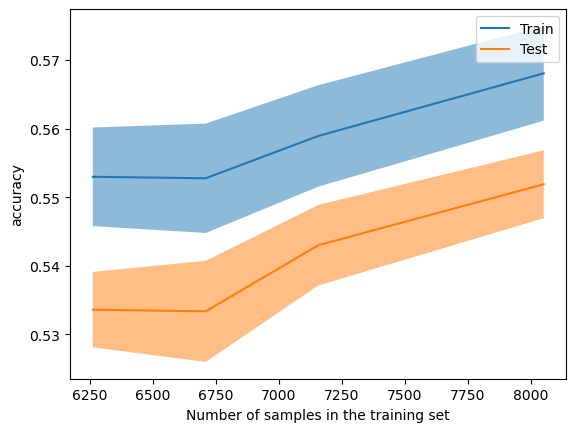

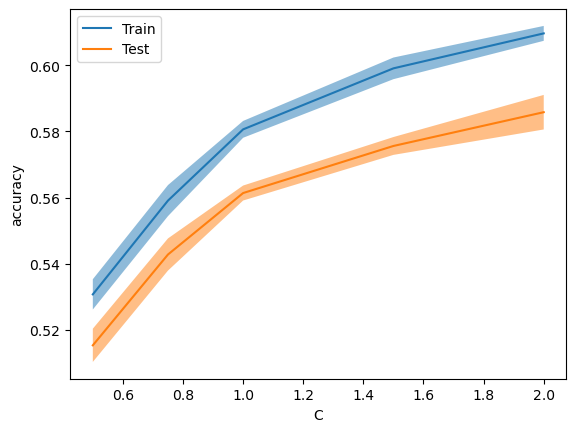

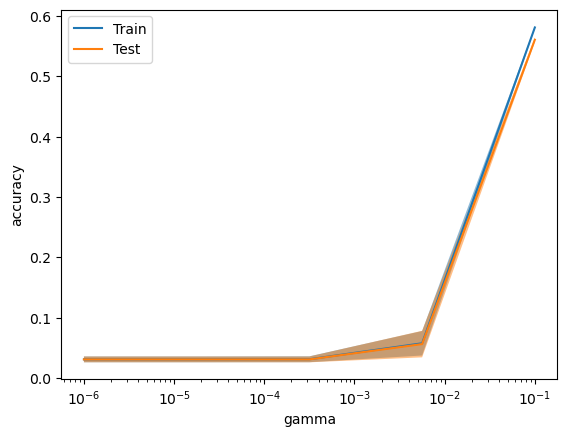

In [80]:
model_name = 'support vector machine'
print(f'Working on: {model_name}')
    
LCtrain_sizes = class_modelsNF[model_name]['LCtrain_sizesnf']
LCtrain_scores = class_modelsNF[model_name]['LCtrain_scoresnf']
LCtest_scores = class_modelsNF[model_name]['LCtest_scoresnf']

VCtrain_scores1 = class_modelsNF[model_name]['VCtrain_scores1nf']
VCtest_scores1 = class_modelsNF[model_name]['VCtest_scores1nf']

VCtrain_scores2 = class_modelsNF[model_name]['VCtrain_scores2nf']
VCtest_scores2 = class_modelsNF[model_name]['VCtest_scores2nf']

param1_name = nf_params[model_name]['param1_name']
param1_range = nf_params[model_name]['param1_range']

param2_name = nf_params[model_name]['param2_name']
param2_range = nf_params[model_name]['param2_range']    

LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                train_scores=LCtrain_scores,
                                test_scores=LCtest_scores,
                                score_name="accuracy")

VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                    param_range=param1_range,
                                    train_scores=VCtrain_scores1,
                                    test_scores=VCtest_scores1,
                                    score_name="accuracy")

VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                    param_range=param2_range,
                                    train_scores=VCtrain_scores2,
                                    test_scores=VCtest_scores2,
                                    score_name="accuracy")
print(f'LC ({model_name})')
LCdisplay.plot()

print(f'VC: Hyper 1 ({param1_name})')    
VCdisplay1.plot()

print(f'VC: Hyper 2 ({param2_name})\n')
VCdisplay2.plot()

plt.show()

$$
\textbf{TESTING SVM END}\\
\textbf{TESTING SVM END}\\
\textbf{TESTING SVM END}
$$

### Visualize Model LC and VC: Nutrition Facts

Working on: decision tree
LC (decision tree)
VC: Hyper 1 (min_samples_split)
VC: Hyper 2 (max_depth)



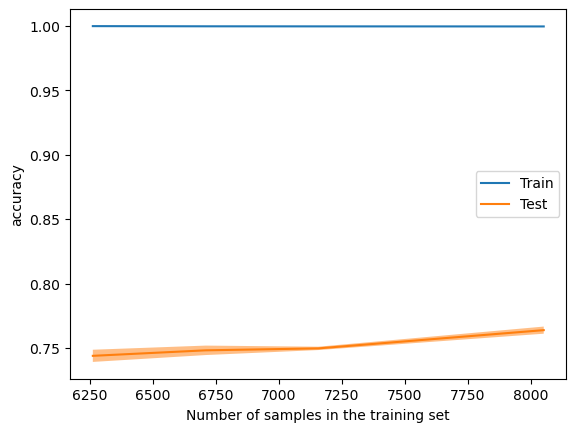

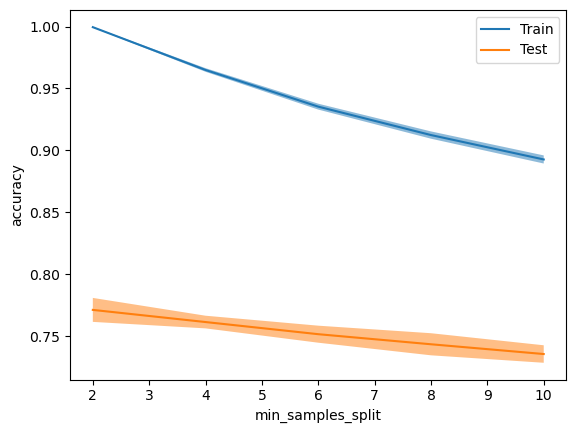

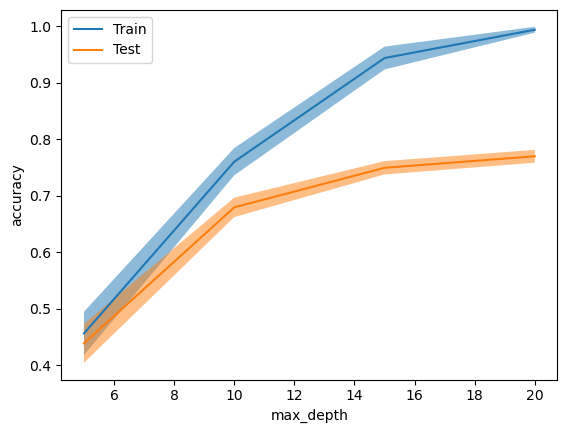

Working on: knn
LC (knn)
VC: Hyper 1 (n_neighbors)
VC: Hyper 2 (leaf_size)



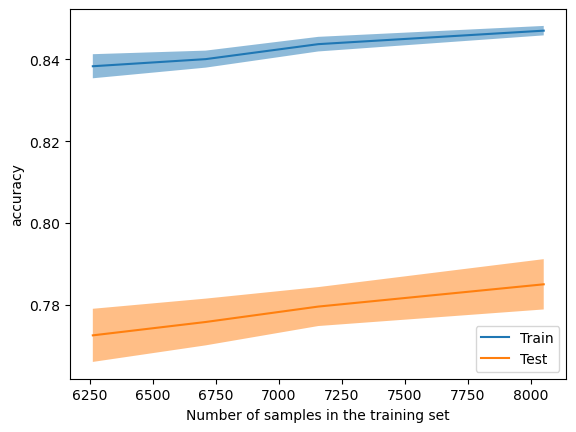

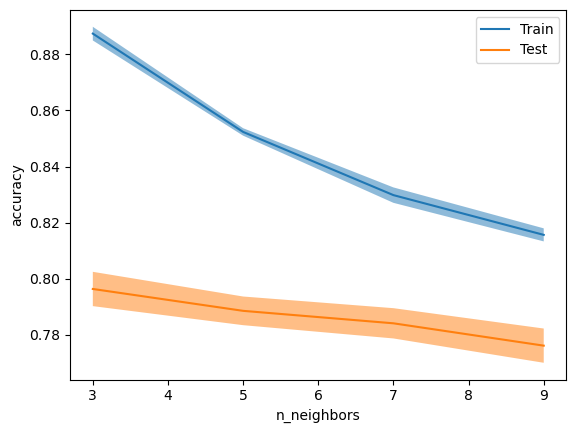

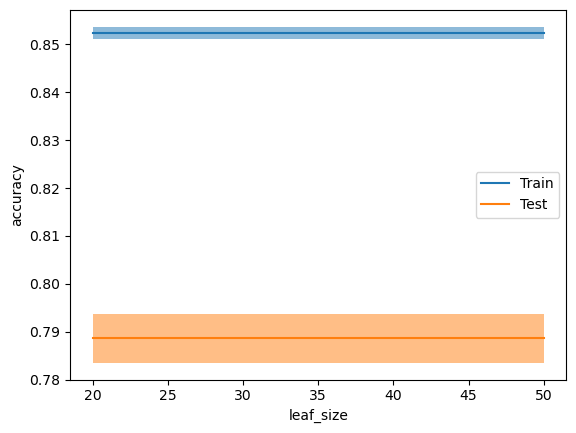

Working on: gradient boosting
LC (gradient boosting)
VC: Hyper 1 (n_estimators)
VC: Hyper 2 (subsample)



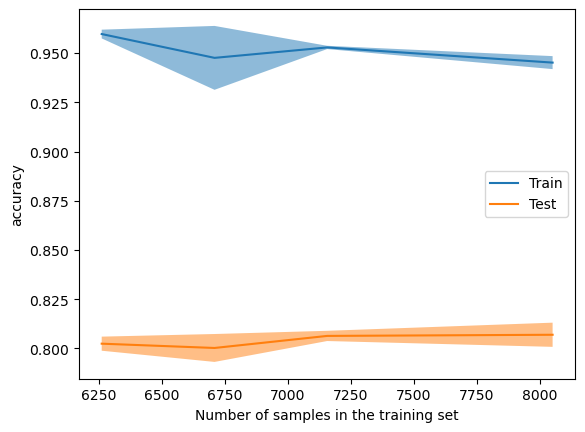

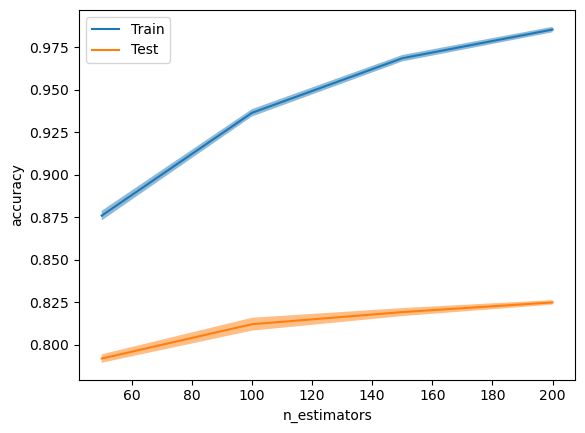

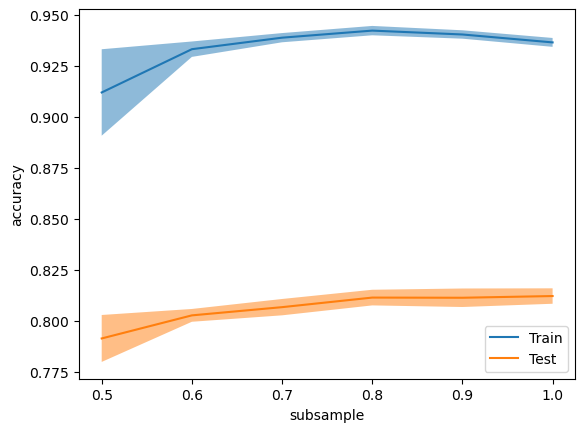

Working on: support vector machine
LC (support vector machine)
VC: Hyper 1 (C)
VC: Hyper 2 (gamma)



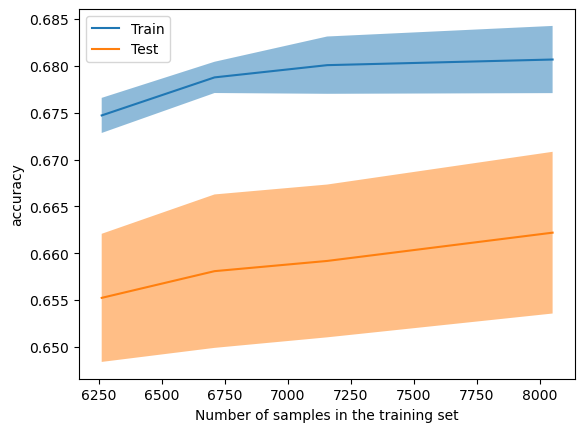

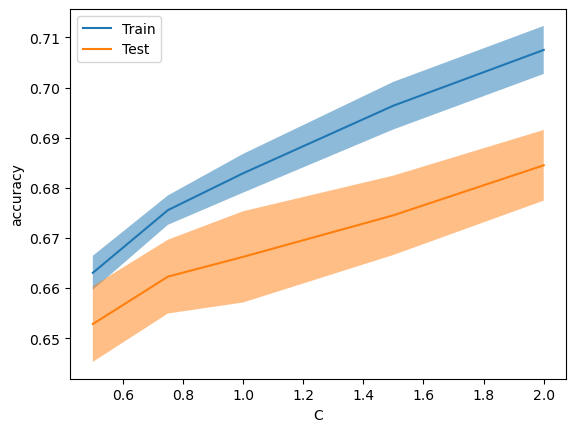

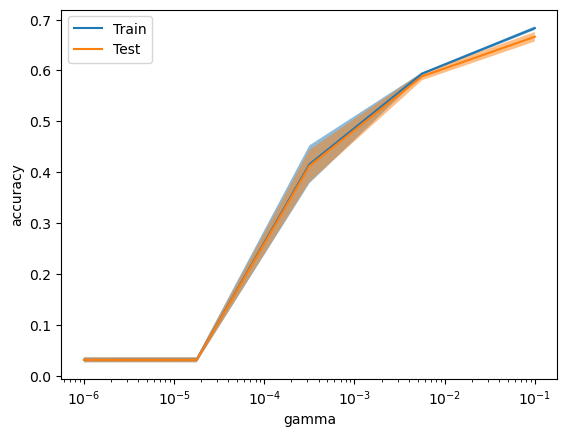

Working on: mlp
LC (mlp)
VC: Hyper 1 (batch_size)
VC: Hyper 2 (hidden_layer_sizes)



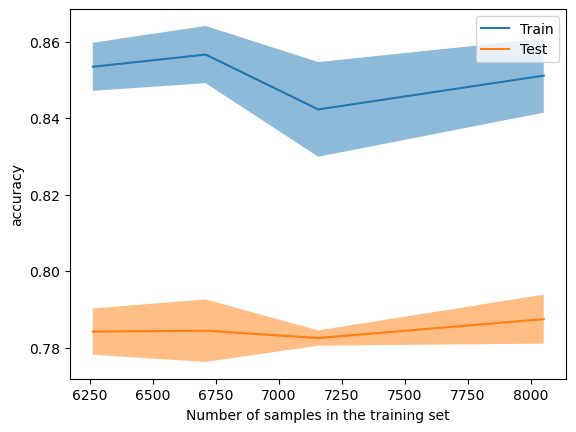

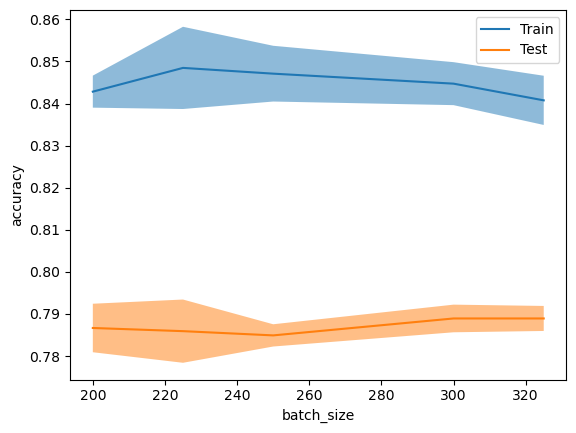

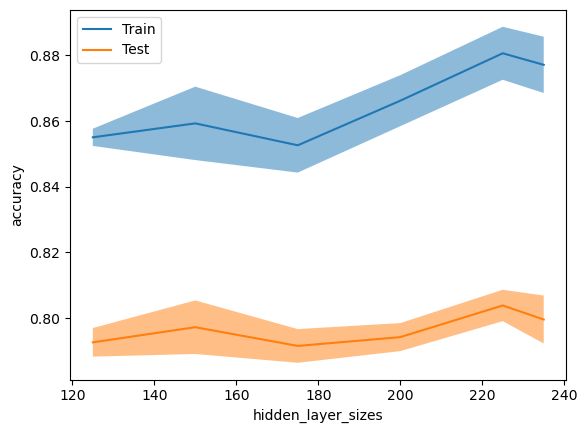

In [43]:
for model_name in class_modelsNF.keys():
    print(f'Working on: {model_name}')
    
    LCtrain_sizes = class_modelsNF[model_name]['LCtrain_sizesnf']
    LCtrain_scores = class_modelsNF[model_name]['LCtrain_scoresnf']
    LCtest_scores = class_modelsNF[model_name]['LCtest_scoresnf']

    VCtrain_scores1 = class_modelsNF[model_name]['VCtrain_scores1nf']
    VCtest_scores1 = class_modelsNF[model_name]['VCtest_scores1nf']

    VCtrain_scores2 = class_modelsNF[model_name]['VCtrain_scores2nf']
    VCtest_scores2 = class_modelsNF[model_name]['VCtest_scores2nf']

    param1_name = nf_params[model_name]['param1_name']
    param1_range = nf_params[model_name]['param1_range']

    param2_name = nf_params[model_name]['param2_name']
    param2_range = nf_params[model_name]['param2_range']    

    LCdisplay = LearningCurveDisplay(train_sizes=LCtrain_sizes,
                                   train_scores=LCtrain_scores,
                                   test_scores=LCtest_scores,
                                   score_name="accuracy")

    VCdisplay1 = ValidationCurveDisplay(param_name=param1_name,
                                        param_range=param1_range,
                                        train_scores=VCtrain_scores1,
                                        test_scores=VCtest_scores1,
                                        score_name="accuracy")

    VCdisplay2 = ValidationCurveDisplay(param_name=param2_name,
                                        param_range=param2_range,
                                        train_scores=VCtrain_scores2,
                                        test_scores=VCtest_scores2,
                                        score_name="accuracy")
    print(f'LC ({model_name})')
    LCdisplay.plot()
    
    print(f'VC: Hyper 1 ({param1_name})')    
    VCdisplay1.plot()
    
    print(f'VC: Hyper 2 ({param2_name})\n')
    VCdisplay2.plot()

    plt.show()
    

#### Final Model: Nutrition Facts

In [ ]:
# y_train_pred = fitted_learning_curve.predict(X_train.values)
# y_test_prob = fitted_learning_curve.predict_proba(X_test.values)[:,1]
# y_test_pred = np.where(y_test_prob > 0.5, 1, 0)

# metrics
# class_modelsNF[model_name]['Accuracy_train'] = accuracy_score(y_train_class, y_train_pred)
# class_modelsNF[model_name]['Accuracy_test'] = accuracy_score(y_test_class, y_test_pred)
# class_modelsNF[model_name]['Recall_train'] = recall_score(y_train_class, y_train_pred)
# class_modelsNF[model_name]['Recall_test'] = recall_score(y_test_class, y_test_pred)
# class_modelsNF[model_name]['precision_train'] = recall_score(y_train_class, y_train_pred)
# class_modelsNF[model_name]['precision_test'] = recall_score(y_test_class, y_test_pred)
# class_modelsNF[model_name]['F1_test'] = f1_score(y_test_class, y_test_pred)

#### Neural Network (PyTorch)

In [ ]:
# import copy

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import tqdm
# from sklearn.metrics import roc_curve
# from sklearn.model_selection import StratifiedKFold, train_test_split
# from sklearn.preprocessing import LabelEncoder

# # Read data
# data = pd.read_csv("sonar.csv", header=None)
# X = data.iloc[:, 0:60]
# y = data.iloc[:, 60]

# # Binary encoding of labels
# encoder = LabelEncoder()
# encoder.fit(y)
# y = encoder.transform(y)

# # Convert to 2D PyTorch tensors
# X = torch.tensor(X.values, dtype=torch.float32)
# y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# # Define two models
# class Wide(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.hidden = nn.Linear(60, 180)
#         self.relu = nn.ReLU()
#         self.output = nn.Linear(180, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.relu(self.hidden(x))
#         x = self.sigmoid(self.output(x))
#         return x

# class Deep(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.layer1 = nn.Linear(60, 60)
#         self.act1 = nn.ReLU()
#         self.layer2 = nn.Linear(60, 60)
#         self.act2 = nn.ReLU()
#         self.layer3 = nn.Linear(60, 60)
#         self.act3 = nn.ReLU()
#         self.output = nn.Linear(60, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         x = self.act1(self.layer1(x))
#         x = self.act2(self.layer2(x))
#         x = self.act3(self.layer3(x))
#         x = self.sigmoid(self.output(x))
#         return x

# # Compare model sizes
# model1 = Wide()
# model2 = Deep()
# print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
# print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

# # Helper function to train one model
# def model_train(model, X_train, y_train, X_val, y_val):
#     # loss function and optimizer
#     loss_fn = nn.BCELoss()  # binary cross entropy
#     optimizer = optim.Adam(model.parameters(), lr=0.0001)

#     n_epochs = 300   # number of epochs to run
#     batch_size = 10  # size of each batch
#     batch_start = torch.arange(0, len(X_train), batch_size)

#     # Hold the best model
#     best_acc = - np.inf   # init to negative infinity
#     best_weights = None

#     for epoch in range(n_epochs):
#         model.train()
#         with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
#             bar.set_description(f"Epoch {epoch}")
#             for start in bar:
#                 # take a batch
#                 X_batch = X_train[start:start+batch_size]
#                 y_batch = y_train[start:start+batch_size]
#                 # forward pass
#                 y_pred = model(X_batch)
#                 loss = loss_fn(y_pred, y_batch)
#                 # backward pass
#                 optimizer.zero_grad()
#                 loss.backward()
#                 # update weights
#                 optimizer.step()
#                 # print progress
#                 acc = (y_pred.round() == y_batch).float().mean()
#                 bar.set_postfix(
#                     loss=float(loss),
#                     acc=float(acc)
#                 )
#         # evaluate accuracy at end of each epoch
#         model.eval()
#         y_pred = model(X_val)
#         acc = (y_pred.round() == y_val).float().mean()
#         acc = float(acc)
#         if acc > best_acc:
#             best_acc = acc
#             best_weights = copy.deepcopy(model.state_dict())
#     # restore model and return best accuracy
#     model.load_state_dict(best_weights)
#     return best_acc

# # train-test split: Hold out the test set for final model evaluation
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# # define 5-fold cross validation test harness
# kfold = StratifiedKFold(n_splits=5, shuffle=True)
# cv_scores_wide = []
# for train, test in kfold.split(X_train, y_train):
#     # create model, train, and get accuracy
#     model = Wide()
#     acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
#     print("Accuracy (wide): %.2f" % acc)
#     cv_scores_wide.append(acc)
# cv_scores_deep = []
# for train, test in kfold.split(X_train, y_train):
#     # create model, train, and get accuracy
#     model = Deep()
#     acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
#     print("Accuracy (deep): %.2f" % acc)
#     cv_scores_deep.append(acc)

# # evaluate the model
# wide_acc = np.mean(cv_scores_wide)
# wide_std = np.std(cv_scores_wide)
# deep_acc = np.mean(cv_scores_deep)
# deep_std = np.std(cv_scores_deep)
# print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
# print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

# # rebuild model with full set of training data
# if wide_acc > deep_acc:
#     print("Retrain a wide model")
#     model = Wide()
# else:
#     print("Retrain a deep model")
#     model = Deep()
# acc = model_train(model, X_train, y_train, X_test, y_test)
# print(f"Final model accuracy: {acc*100:.2f}%")

# model.eval()
# with torch.no_grad():
#     # Test out inference with 5 samples
#     for i in range(5):
#         y_pred = model(X_test[i:i+1])
#         print(f"{X_test[i].numpy()} -> {y_pred[0].numpy()} (expected {y_test[i].numpy()})")

#     # Plot the ROC curve
#     y_pred = model(X_test)
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred)
#     plt.plot(fpr, tpr) # ROC curve = TPR vs FPR
#     plt.title("Receiver Operating Characteristics")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.show()

### LOGISTIC REGRESSION
# import torch
# import numpy as np
# from sklearn import datasets
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# nn = torch.nn

# # 0) prepare data
# bc = datasets.load_breast_cancer()
# x, y = bc.data, bc.target

# n_samples, n_features = x.shape
# print(n_samples, n_features)

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=1234)

# # scale
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# X_train = torch.from_numpy(X_train.astype(np.float32))
# X_test = torch.from_numpy(X_test.astype(np.float32))
# y_train = torch.from_numpy(y_train.astype(np.float32))
# y_test = torch.from_numpy(y_test.astype(np.float32))

# y_train = y_train.view(y_train.shape[0], 1)
# y_test = y_test.view(y_test.shape[0], 1)

# # 1) model
# # f = wx + b, sigmoid at the end
# class LogisticRegression(nn.Module):

#     def __init__(self, n_input_features):
#         super(LogisticRegression, self).__init__()
#         self.linear = nn.Linear(n_input_features, out_features=1)

#     def forward(self, x):
#         y_pred = torch.sigmoid(self.linear(x))
#         return y_pred

# model = LogisticRegression(n_features)

# # # 2) loss and optimizer
# lr = .01
# criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# # # 3) training loop
# n_epochs = 100
# for epoch in range(n_epochs):
#     # forward pass and loss
#     y_pred = model(X_train)
#     loss = criterion(y_pred, y_train)

#     # backward pass
#     loss.backward()

#     # update
#     optimizer.step()

#     # zero gradients
#     optimizer.zero_grad()

#     if (epoch + 1) % 10 == 0:
#         print(f"epoch: {epoch+1}, loss = {loss.item()}")


# with torch.no_grad():
#     y_predicted = model(X_test)
#     y_predicted_cls = y_predicted.round()
#     acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
#     print(f"accuracy = {acc}")